## Outlier Detection with contaminated MNIST dataset

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

mnist_df = pd.read_csv('MNIST_1_woc.csv') # 1 is true label, rest are outliers
mnist_df.head()

,0,1,2,3,4,5,6,7,8,9,...,776,777,778,779,780,781,782,783,image-class,outlier
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,no
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,no
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,no
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,no
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,no


In [12]:
mnist_df['image-class'].unique()
mnist_df['image-class'].value_counts()

image-class
1    7877
9      98
6      96
7      94
8      91
4      88
0      87
3      83
2      76
5      75
Name: count, dtype: int64

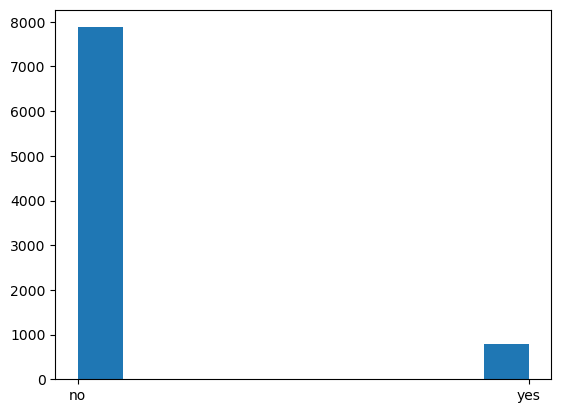

(array([  87., 7877.,   76.,   83.,   88.,   75.,   96.,   94.,   91.,
          98.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

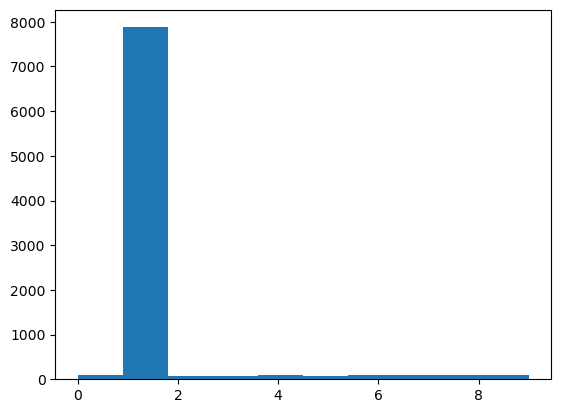

In [13]:
plt.hist(mnist_df.outlier)
plt.show()
plt.hist(mnist_df['image-class'])

### Preprocess

In [114]:
from sklearn.model_selection import train_test_split
X = mnist_df[mnist_df.outlier == 'no'].drop(['image-class', 'outlier'], axis=1).values
X = (X.T / X.T.max()).T
X_outliers = mnist_df[mnist_df.outlier == 'yes'].drop(['image-class', 'outlier'], axis=1).values
X_outliers = (X_outliers.T / X_outliers.T.max()).T
X_train, X_test = train_test_split(X, test_size=0.8, random_state=0)
print(X_train.shape, X_test.shape)

(1575, 784) (6302, 784)


### Dimension Reduction

(8665, 784) (8665, 2)


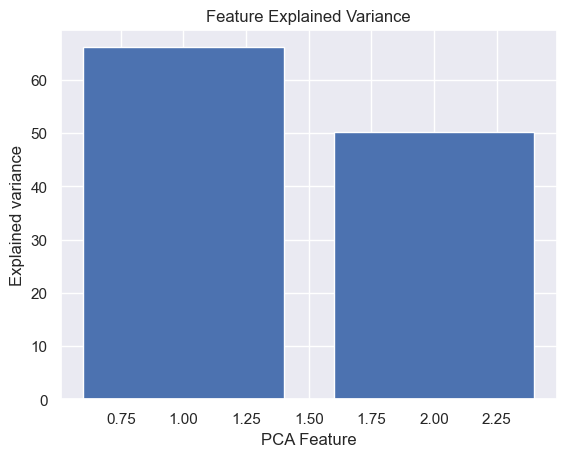

In [169]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
sns.set() 

X_all_orig = mnist_df.drop(['image-class', 'outlier'], axis=1).values

# Data Scaling
X_all = StandardScaler().fit_transform(X_all)

k = 2
 
# Reduce to 2 features with PCA
pca = PCA(n_components=k)
X_all_red = pca.fit_transform(X_all)

print(X_all.shape, X_all_red.shape)

# Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

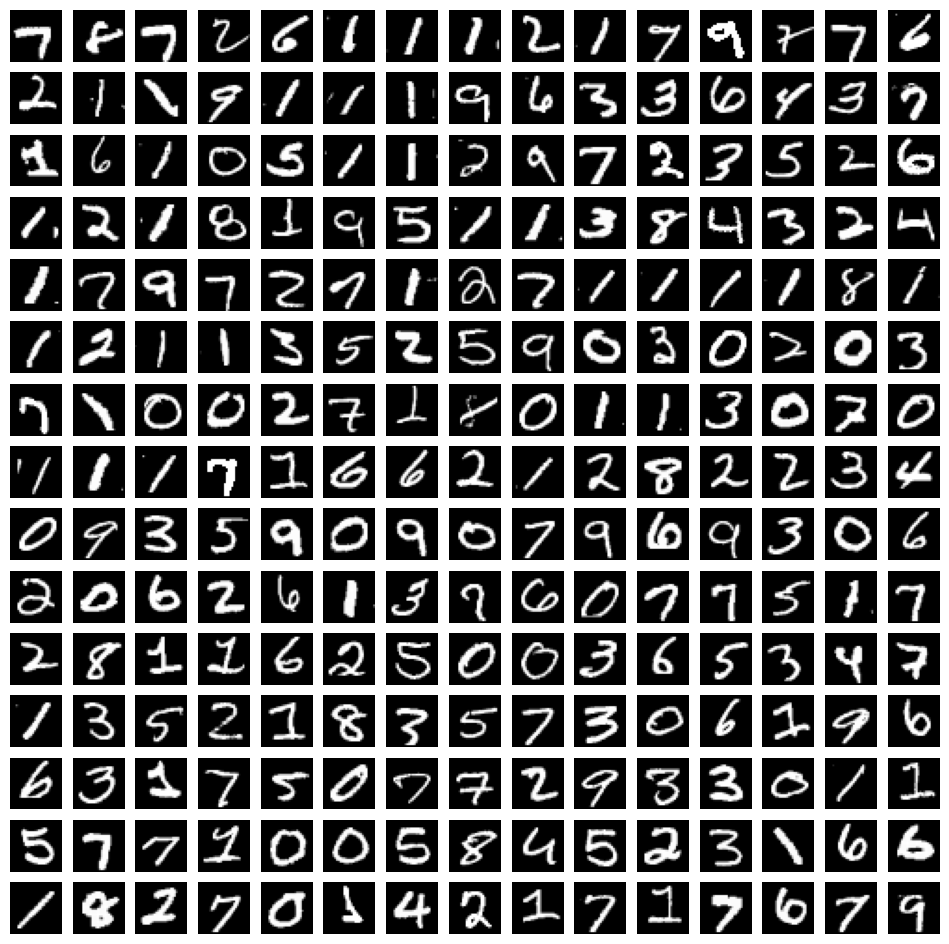

In [170]:
X_all_rec = pca.inverse_transform(X_all_red)
X_all_rec.shape
rec_err = np.sum((X_all_rec - X_all)**2, axis=1)
#len(rec_err)
out_indices = np.argsort(-rec_err)[:225]
plt.figure(figsize=(12,12))
plt.gray()
for i in range(len(out_indices)):
    plt.subplot(15,15,i+1), plt.imshow(X_all_orig[out_indices[i]].reshape(28,28)), plt.axis('off')
plt.show()

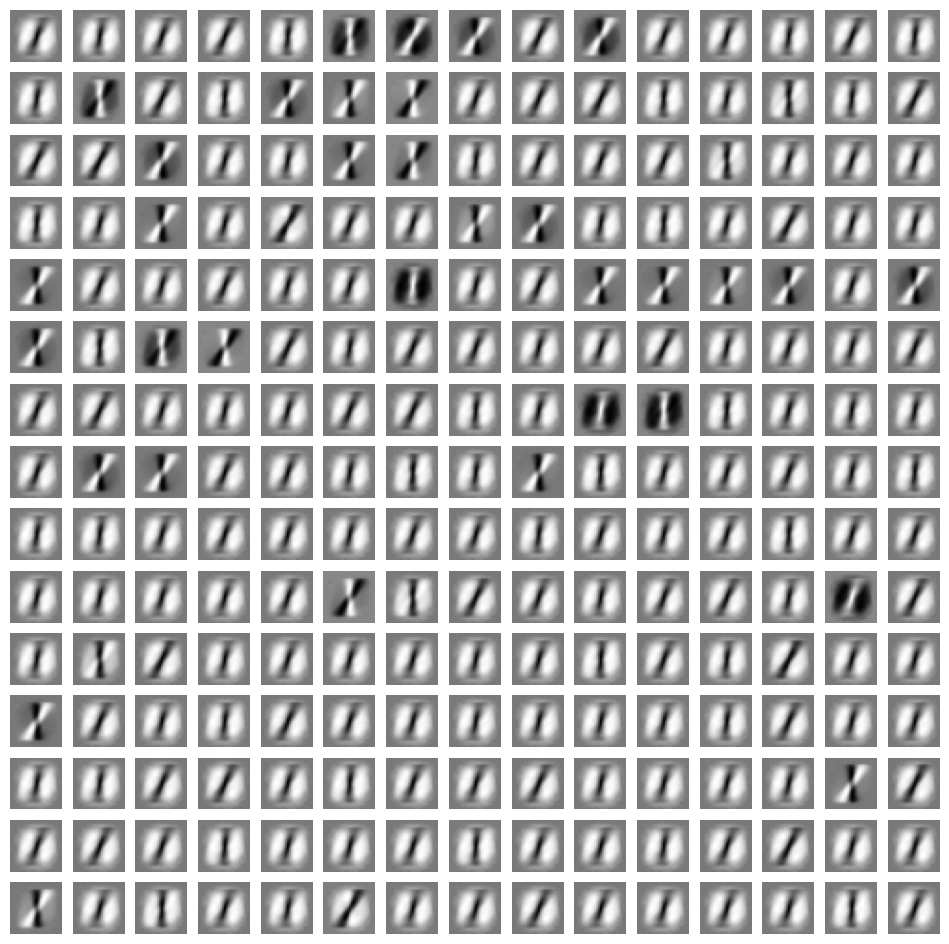

In [171]:
plt.figure(figsize=(12,12))
plt.gray()
for i in range(len(out_indices)):
    plt.subplot(15,15,i+1), plt.imshow(X_all_rec[out_indices[i]].reshape(28,28)), plt.axis('off')
plt.show()

### Visualization

In [155]:
from sklearn.manifold import TSNE
n_in, n_out = 500, 500
X_all = np.vstack((X[np.random.choice(len(X), n_in)], X_outliers[np.random.choice(len(X_outliers), n_out)]))
X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(X_all)

In [156]:
X_all.shape

(1000, 784)

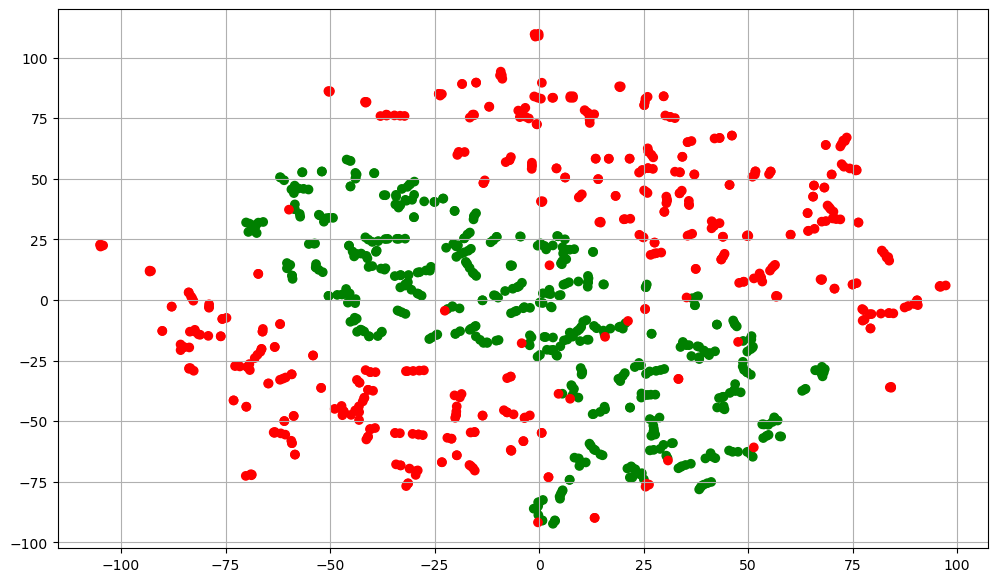

In [158]:
#map_c = {'no': 'g', 'yes': 'r'}
plt.figure(figsize=(12,7))
plt.scatter(X_embedded[:,0], X_embedded[:,1], color=['g']*n_in + ['r']*n_out) #color=[map_c[x] for x in mnist_df.outlier.tolist()])
plt.grid()
plt.show()

### One-class SVM

In [115]:
from sklearn import svm
clf = svm.OneClassSVM(gamma='auto', kernel='rbf', nu=0.1) #nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

In [109]:
#from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
#param_grid = {'nu': [0.1, 1, 10, 100, 1000],  
#              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
#              'kernel': ['rbf']}  
  
#grid = GridSearchCV(svm.OneClassSVM(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
#grid.fit(X_train) 

In [110]:
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size
(n_error_train, n_error_test, n_error_outliers)

(156, 766, 11)

In [111]:
from collections import Counter
Counter(y_pred_train)

Counter({1: 1419, -1: 156})

(156, 784)


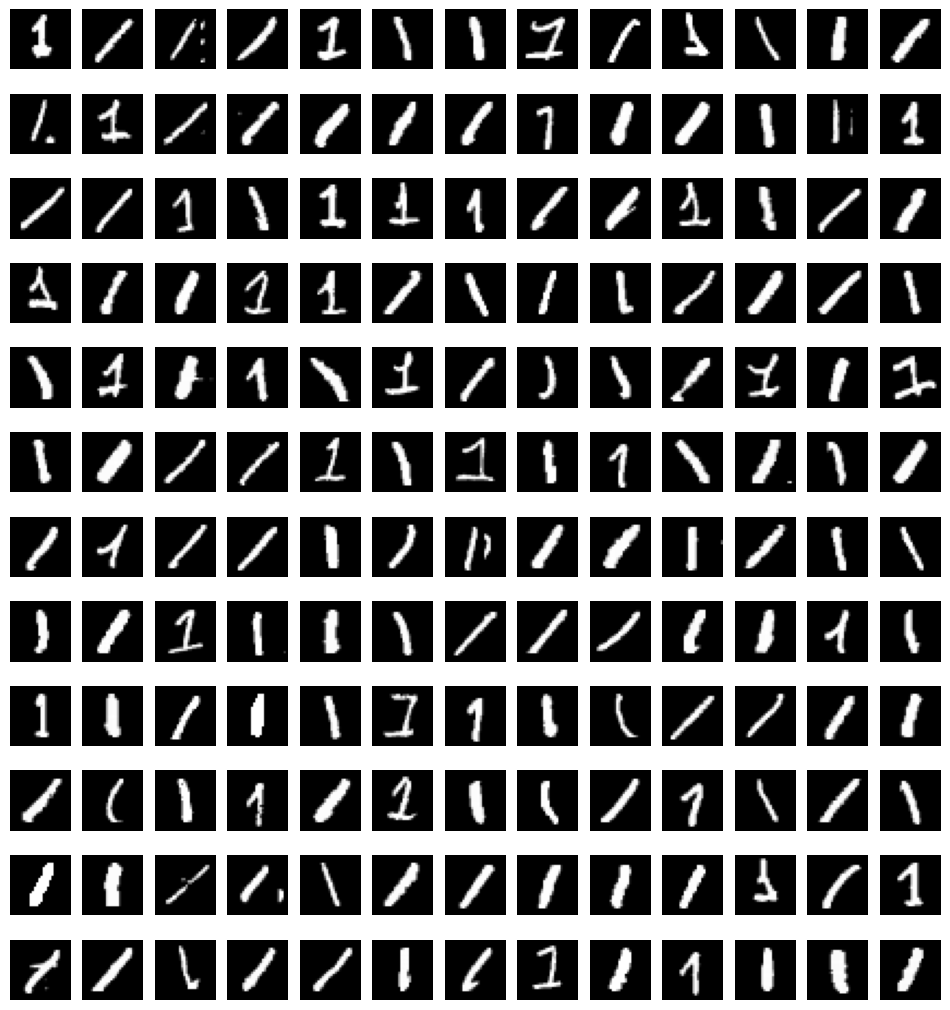

In [112]:
X_train_wrong_pred = X_train[y_pred_train == -1]
print(X_train_wrong_pred.shape)
plt.figure(figsize=(12,13))
plt.gray()
for i in range(len(X_train_wrong_pred)):
    plt.subplot(12,13,i+1), plt.imshow(X_train_wrong_pred[i].reshape(28,28)), plt.axis('off')
plt.show()

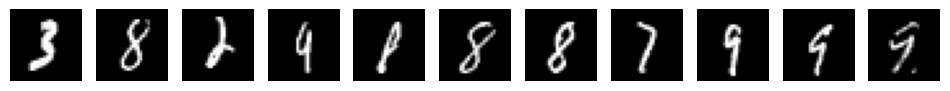

In [113]:
X_outliers_wrong_pred = X_outliers[y_pred_outliers == 1]
plt.figure(figsize=(12,3))
plt.gray()
for i in range(len(X_outliers_wrong_pred)):
    plt.subplot(1,11,i+1), plt.imshow(X_outliers_wrong_pred[i].reshape(28,28)), plt.axis('off')
plt.show()

### Isolation Forest

In [116]:
from sklearn.ensemble import IsolationForest
X_all = np.hstack((X, X_))

clf = IsolationForest(max_samples=100, random_state=0)
clf.fit_predict(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

In [117]:
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size
(n_error_train, n_error_test, n_error_outliers)

(158, 734, 13)

In [118]:
Counter(y_pred_train)

Counter({-1: 158, 1: 1417})

(158, 784)


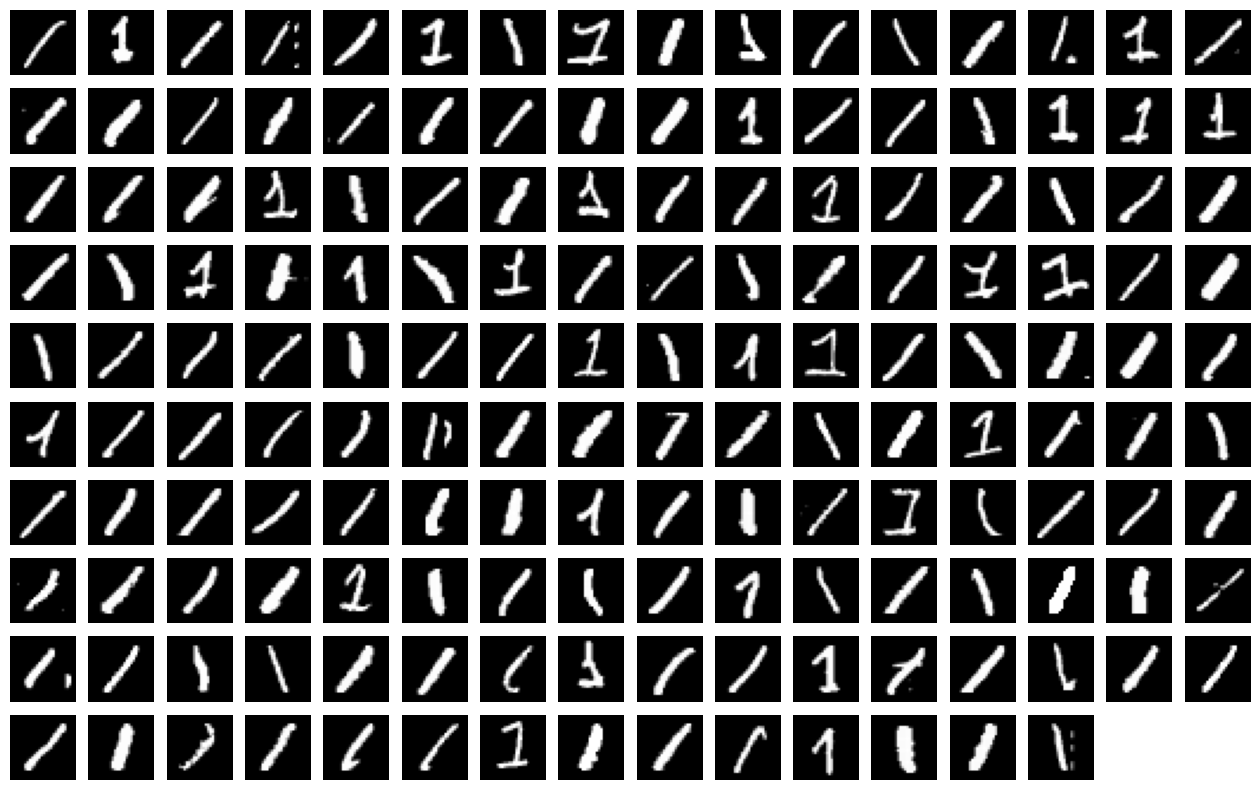

In [120]:
X_train_wrong_pred = X_train[y_pred_train == -1]
print(X_train_wrong_pred.shape)
plt.figure(figsize=(16,10))
plt.gray()
for i in range(len(X_train_wrong_pred)):
    plt.subplot(10,16,i+1), plt.imshow(X_train_wrong_pred[i].reshape(28,28)), plt.axis('off')
plt.show()

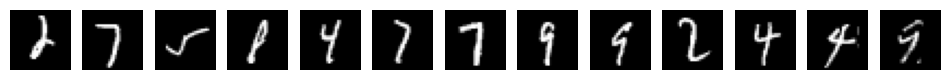

In [121]:
X_outliers_wrong_pred = X_outliers[y_pred_outliers == 1]
plt.figure(figsize=(12,3))
plt.gray()
for i in range(len(X_outliers_wrong_pred)):
    plt.subplot(1,13,i+1), plt.imshow(X_outliers_wrong_pred[i].reshape(28,28)), plt.axis('off')
plt.show()

### LOF

In [129]:
from sklearn.neighbors import LocalOutlierFactor
X_all = mnist_df.drop(['image-class', 'outlier'], axis=1).values
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred_all = clf.fit_predict(X_all)
Counter(y_pred_all)

Counter({1: 7798, -1: 867})

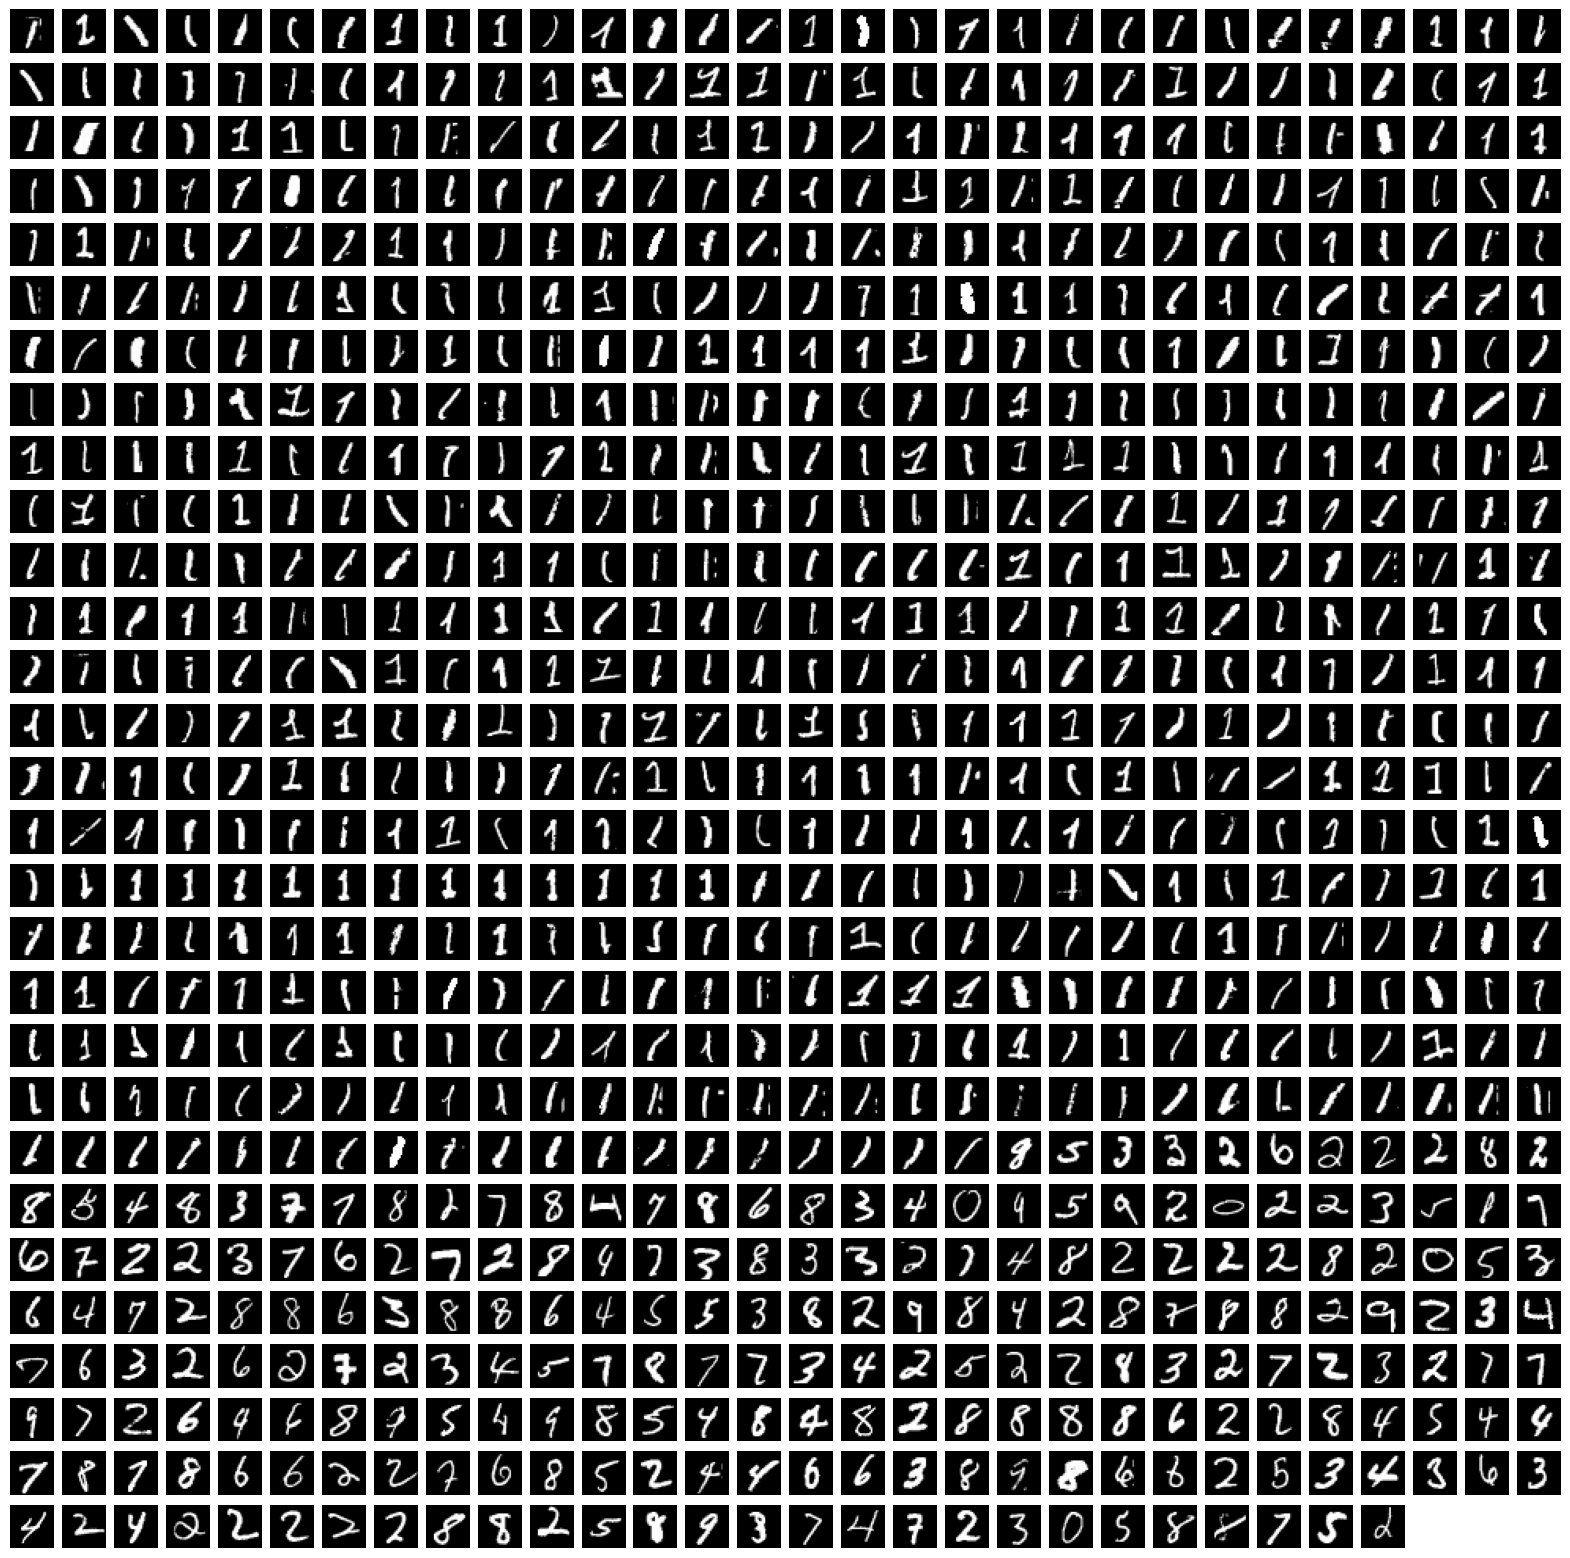

In [132]:
X_outliers_pred = X_all[y_pred_all == -1]
plt.figure(figsize=(20,20))
plt.gray()
for i in range(len(X_outliers_pred)):
    plt.subplot(29,30,i+1), plt.imshow(X_outliers_pred[i].reshape(28,28)), plt.axis('off')
plt.show()

### With EllipticEnvelop

In [133]:
from sklearn.covariance import EllipticEnvelope
clf = EllipticEnvelope(random_state=0).fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

C:\Users\Sandipan.Dey\anaconda3\envs\py38\lib\site-packages\sklearn\covariance\_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


In [134]:
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size
(n_error_train, n_error_test, n_error_outliers)

(158, 724, 179)

In [135]:
Counter(y_pred_train)

Counter({-1: 158, 1: 1417})

(158, 784)


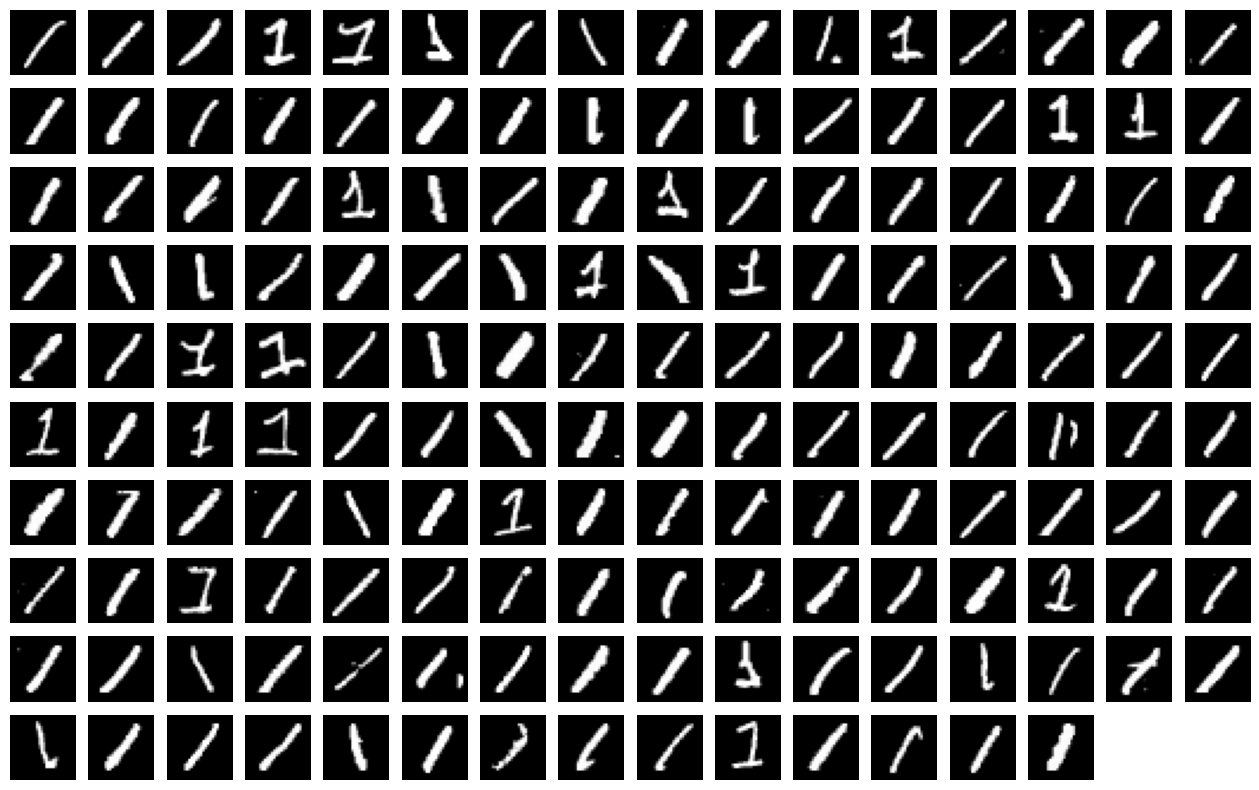

In [136]:
X_train_wrong_pred = X_train[y_pred_train == -1]
print(X_train_wrong_pred.shape)
plt.figure(figsize=(16,10))
plt.gray()
for i in range(len(X_train_wrong_pred)):
    plt.subplot(10,16,i+1), plt.imshow(X_train_wrong_pred[i].reshape(28,28)), plt.axis('off')
plt.show()

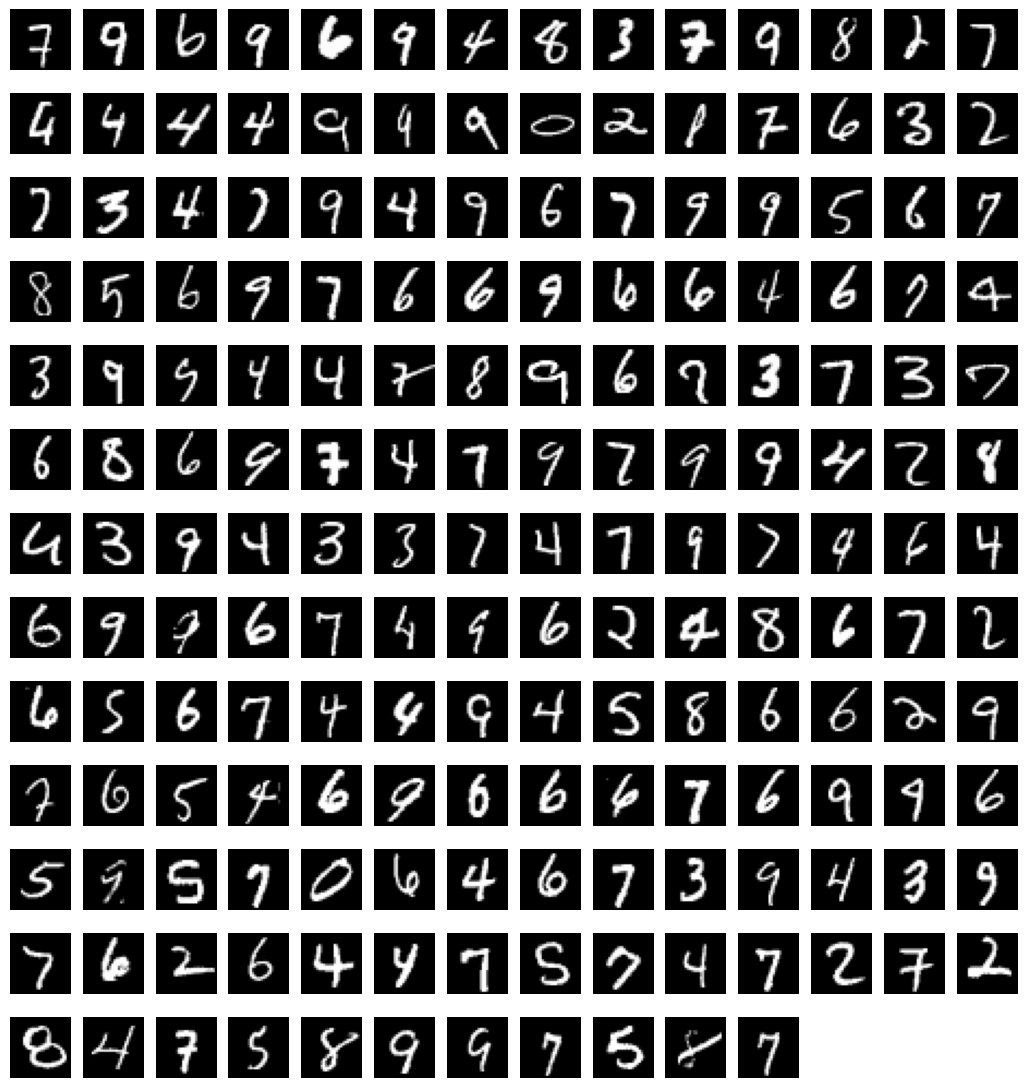

In [138]:
X_outliers_wrong_pred = X_outliers[y_pred_outliers == 1]
plt.figure(figsize=(13,14))
plt.gray()
for i in range(len(X_outliers_wrong_pred)):
    plt.subplot(13,14,i+1), plt.imshow(X_outliers_wrong_pred[i].reshape(28,28)), plt.axis('off')
plt.show()